In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import HTML, display
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn_pandas import DataFrameMapper

plt.rcParams['figure.figsize'] = 25, 10

In [3]:
def load_notebook_config(width=True):
    pd.options.display.max_columns = 0
    plt.rcParams.update({
        "font.family": ["serif"],
        "font.sans-serif": ["Roboto"],
        "font.size": 9,
        "axes.labelsize": 11,
        "axes.titlesize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        'figure.figsize': (15.0, 4.0),
        'axes.grid': False,
        'axes.spines.left': True,
        'axes.spines.right': True,
        'axes.spines.top': True,
        'axes.spines.bottom': True,
    })
    if width:
        display(HTML("<style>.container { width:90% !important; }</style>"))

load_notebook_config()

# Leyendo los datos

In [4]:
!head ./train.csv

In [5]:
all_data = pd.read_csv('./train.csv')

BETTER_COLUMN_NAMES = {
    'PassengerId': 'passenger_id',
    'Survived': 'survived',
    'Pclass': 'ticket_class',
    'Name': 'name',
    'Sex': 'sex',
    'Age': 'age',
    'SibSp': 'siblings_spouses',
    'Parch': 'parents_children',
    'Ticket': 'ticket',
    'Fare': 'fare',
    'Cabin': 'cabin',
    'Embarked': 'embarked_at',
    'Survived': 'survived',
}
all_data.rename(columns=BETTER_COLUMN_NAMES, inplace=True)

all_data.set_index('passenger_id', inplace=True)

all_data.shape

(891, 11)

#### Distribución de valores nulos

In [6]:
all_data.isnull().sum()

survived              0
ticket_class          0
name                  0
sex                   0
age                 177
siblings_spouses      0
parents_children      0
ticket                0
fare                  0
cabin               687
embarked_at           2
dtype: int64

### La columna a predecir es:

- survived

### Vamos a usar como entradas:

- sex: male/female
- age: numbers, many NaNs
- siblings_spouses: numbers, no NaNs
- parents_children: numbers, no NaNs
- ticket_class: 1/2/3
- fare: numbers, no NaNs
- embarked_at: C/Q/S and very few NaNs

### No vamos a utilizar:

- passenger_id: this could only lead to overfitting
- name: this has a high change of leading to overfitting
- cabin: very little data, and maybe able to overfit? are these single family/person rooms?

#### Como *embarket_at* tiene muy pocos nulos, directamente vamos a descartar los casos.

In [7]:
to_delete = all_data[all_data.embarked_at.isnull()].index
all_data = all_data.drop(to_delete, axis='index')

In [8]:
all_data.shape

(889, 11)

## Conjuntos de datos

In [9]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(all_data, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

# Pipeline, transformers & estimators

* **estimator**: un **modelo** de Machine Learning. Los métodos más importantes son:
    * fit(X, y): **X** es una matriz de la forma *(n_samples, n_features)*; **y** un array *(n_samples,)*. Devuelve una referencia al estimador
    * predict(X): **X** es una matriz de la forma *(n_samples, n_features)*. Devuelve un array *(n_samples,)* con las predicciones
    
* **Transformers** y **pre-processors**: Son objetos para aplicar transformaciones y preprocesamientos (standarización, imputación de nulos, etc..) antes de entrenar un modelo. Los métodos más importantes son:
    * fit(X, y): idem al fit de un estimador
    * transform(X): Devuelve una matriz de la forma *(n_samples, n_features_new)*, donde n_features_new es la cantidad de features determinadas en el entrenamiento
    
    https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing
    
    
* **Pipeline**: Es un objeto que permite encadenar uno o más transformers con un estimador final. Sigue la misma interfaz que el estimador final.

* **Feature Union**: En un objeto que permite *concatenar* las salidas de uno o mas transformers.
   

   
![](../images/pipeline.svg)
    

# DataFrame Mapper

Nos facilita la integración de Pandas con sklearn.

![](../images/dataframe_mapper.svg)



## Preparando el mapper

In [10]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
# Una primer version...
# Definimos el mapper. Recibe una lista de (columna/s, transformers)
mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['sex'], [OneHotEncoder()])
])

# Lo entrenamos con train
mapper.fit(train)

# vemos como transforma un sample:
sample = train.sample(5, random_state=42)

display('Sample original')
display(sample)

display('Sample transformado')
display(mapper.transform(sample))

display('Nombres de los faetures')
mapper.transformed_names_

'Sample original'

,survived,ticket_class,name,sex,age,siblings_spouses,parents_children,ticket,fare,cabin,embarked_at
passenger_id,,,,,,,,,,,
106,0,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,NaN,S
784,0,3,"Johnston, Mr. Andrew G",male,NaN,1,2,W./C. 6607,23.4500,NaN,S
280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S
688,0,3,"Dakic, Mr. Branko",male,19.0,0,0,349228,10.1708,NaN,S
704,0,3,"Gallagher, Mr. Martin",male,25.0,0,0,36864,7.7417,NaN,Q


'Sample transformado'

array([[-0.11193044,  0.        ,  1.        ],
       [        nan,  0.        ,  1.        ],
       [ 0.36886349,  1.        ,  0.        ],
       [-0.73009407,  0.        ,  1.        ],
       [-0.31798499,  0.        ,  1.        ]])

'Nombres de los faetures'

['age', 'sex_x0_female', 'sex_x0_male']

### Y los nulos???

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute

In [12]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import Pipeline

In [13]:
mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['sex'], [OneHotEncoder()])
])


pipe1 = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean')),
])
# Lo entrenamos con train
pipe1.fit(train)

pipe2 = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
])
# Lo entrenamos con train
pipe2.fit(train)


display('Sample transformado con mean')
display(pipe1.transform(sample))

display('Sample transformado con Iterative')
display(pipe2.transform(sample))

'Sample transformado con mean'

array([[-1.11930444e-01,  0.00000000e+00,  1.00000000e+00],
       [-1.39300336e-16,  0.00000000e+00,  1.00000000e+00],
       [ 3.68863489e-01,  1.00000000e+00,  0.00000000e+00],
       [-7.30094072e-01,  0.00000000e+00,  1.00000000e+00],
       [-3.17984987e-01,  0.00000000e+00,  1.00000000e+00]])

'Sample transformado con Iterative'

array([[-0.11193044,  0.        ,  1.        ],
       [ 0.00654025,  0.        ,  1.        ],
       [ 0.36886349,  1.        ,  0.        ],
       [-0.73009407,  0.        ,  1.        ],
       [-0.31798499,  0.        ,  1.        ]])

### El mapper completo

In [14]:
complete_mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['siblings_spouses'], [StandardScaler()]),
    (['parents_children'], [StandardScaler()]),
    (['ticket_class'], [StandardScaler()]),
    (['fare'], [StandardScaler()]),
    (['sex'], [OneHotEncoder()]),
    (['embarked_at'], [OneHotEncoder()]),

])

complete_mapper.fit(train)

display('Sample transformado con mean')
display(complete_mapper.transform(sample))

'Sample transformado con mean'

array([[-0.11193044, -0.49121516, -0.49013792,  0.79054795, -0.47297166,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ],
       [        nan,  0.42104157,  1.84239343,  0.79054795, -0.18341222,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ],
       [ 0.36886349,  0.42104157,  0.67612775,  0.79054795, -0.24298392,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [-0.73009407, -0.49121516, -0.49013792,  0.79054795, -0.4306199 ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ],
       [-0.31798499, -0.49121516, -0.49013792,  0.79054795, -0.4758404 ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ]])

# Primer modelo: Regresión logística

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
lr_model_si = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_model_si.fit(train, train.survived)

y_pred = lr_model_si.predict(train)

y_pred

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,

#### sklearn.metrics

Muchas funciones listas para evaluar modelos:

https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [17]:
from sklearn import metrics

print(metrics.classification_report(train.survived, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       335
           1       0.77      0.69      0.73       198

    accuracy                           0.81       533
   macro avg       0.80      0.78      0.79       533
weighted avg       0.80      0.81      0.80       533



#### Programemos una función para evaluar un modelo...

In [18]:
def evaluate_model(model, set_names=('train', 'test'), title='', show_cm=True):
    if title:
        display(title)
    final_metrics = defaultdict(list)
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'test', 'validation']
        set_data = globals()[set_name] # <- hack feo...

        y = set_data.survived
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['died', 'survived'])
            ax.yaxis.set_ticklabels(['died', 'survived'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

,Accuracy,Precision,Recall,F1
train,0.806754,0.768362,0.686869,0.725333
test,0.792135,0.772727,0.698630,0.733813


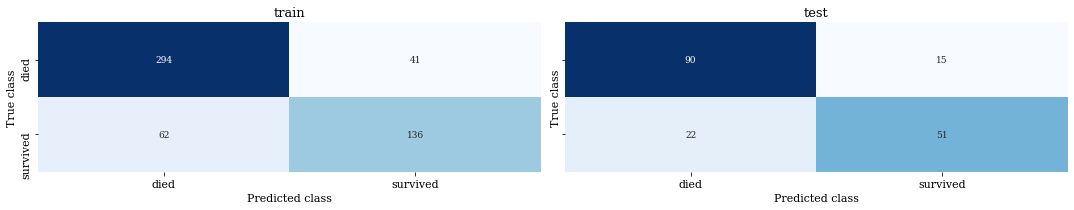

In [19]:
evaluate_model(lr_model_si)

In [20]:
lr_model_si.steps

[('mapper',
  DataFrameMapper(default=False, df_out=False,
                  features=[(['age'],
                             [StandardScaler(copy=True, with_mean=True,
                                             with_std=True)]),
                            (['siblings_spouses'],
                             [StandardScaler(copy=True, with_mean=True,
                                             with_std=True)]),
                            (['parents_children'],
                             [StandardScaler(copy=True, with_mean=True,
                                             with_std=True)]),
                            (['ticket_class'],
                             [StandardScaler(copy=True, with_mean=True,
                                             with_std=True)]),
                            (['fare'],
                             [StandardScaler(copy=True, with_mean=True,
                                             with_std=True)]),
                            (['sex'],
  

array([[-0.64958493, -0.42053457, -0.03837994, -0.91692711,  0.04865513,
         1.34650708, -1.3465123 ,  0.43543752, -0.17852602, -0.25691671]])

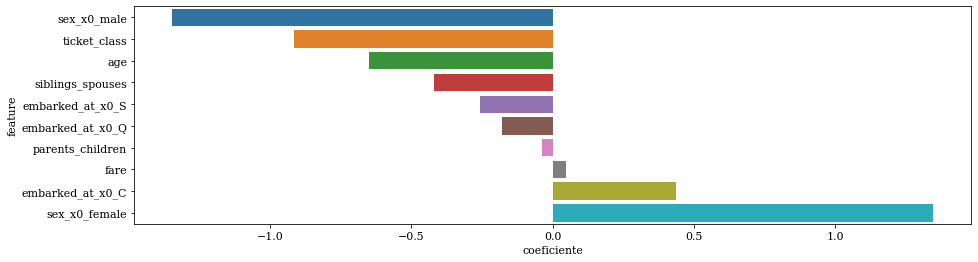

In [21]:
clf = lr_model_si.named_steps['classifier']
display(clf.coef_)

names = complete_mapper.transformed_names_
df_importance = pd.DataFrame({'feature': names, 'coeficiente': clf.coef_[0]}).sort_values(by='coeficiente')
ax = sns.barplot(x='coeficiente', y='feature', data=df_importance)

'LR Simple Imputer'

,Accuracy,Precision,Recall,F1
train,0.806754,0.768362,0.686869,0.725333
test,0.792135,0.772727,0.698630,0.733813


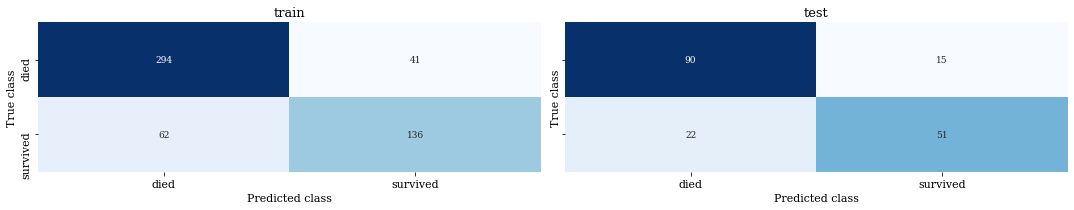

'LR Iterative Imputer'

,Accuracy,Precision,Recall,F1
train,0.808630,0.769663,0.691919,0.728723
test,0.797753,0.784615,0.698630,0.739130


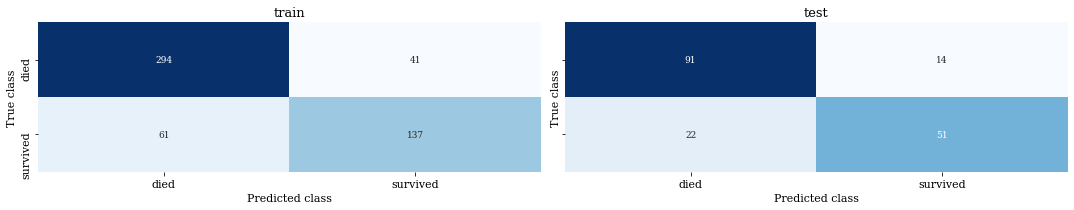

In [22]:
lr_model_ii = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_model_ii.fit(train, train.survived)

evaluate_model(lr_model_si, title='LR Simple Imputer')
evaluate_model(lr_model_ii, title='LR Iterative Imputer')

# Segundo modelo: K nearest neighbors

In [23]:
from sklearn.neighbors import KNeighborsClassifier

'Knn'

,Accuracy,Precision,Recall,F1
train,0.838649,0.858974,0.676768,0.757062
test,0.786517,0.830189,0.602740,0.698413


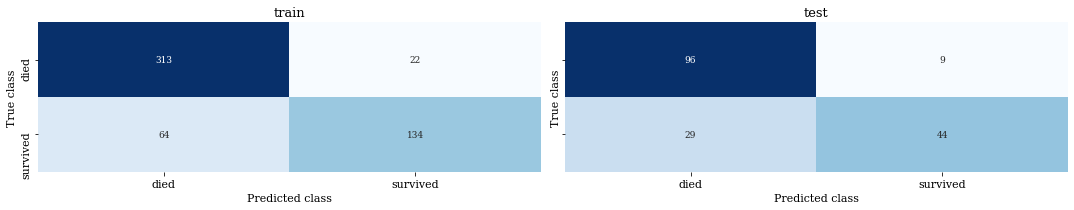

In [24]:
K = 10

knn_model = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

knn_model.fit(train, train.survived)

evaluate_model(knn_model, title='Knn')

# Tercer modelo: Arboles de decisión

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

In [26]:
label_binarizer_mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['siblings_spouses'], [StandardScaler()]),
    (['parents_children'], [StandardScaler()]),
    (['ticket_class'], [StandardScaler()]),
    (['fare'], [StandardScaler()]),
    (['sex'], [LabelBinarizer()]),
    (['embarked_at'], [LabelBinarizer()]),

])

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.988743,0.994845,0.974747,0.984694
test,0.758427,0.720588,0.671233,0.695035


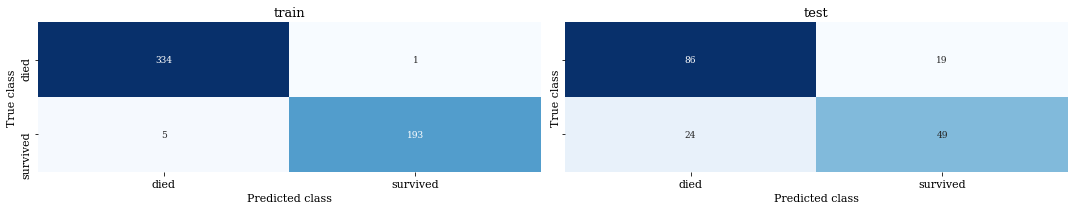

In [27]:
tree_model = DecisionTreeClassifier(random_state=42)
# tree_model = DecisionTreeClassifier(max_depth=3)

dt_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', tree_model),
])

dt_model.fit(train, train.survived)

evaluate_model(dt_model, title='Decision Tree')

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.833021,0.826347,0.696970,0.756164
test,0.792135,0.821429,0.630137,0.713178


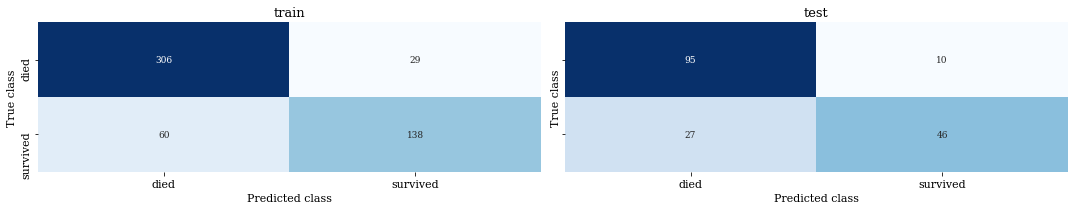

In [28]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)

dt_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', tree_model),
])

dt_model.fit(train, train.survived)

evaluate_model(dt_model, title='Decision Tree')

In [29]:
import graphviz  # pip install graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree, col_names):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=col_names,  
        class_names=['died', 'survived'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    return graph

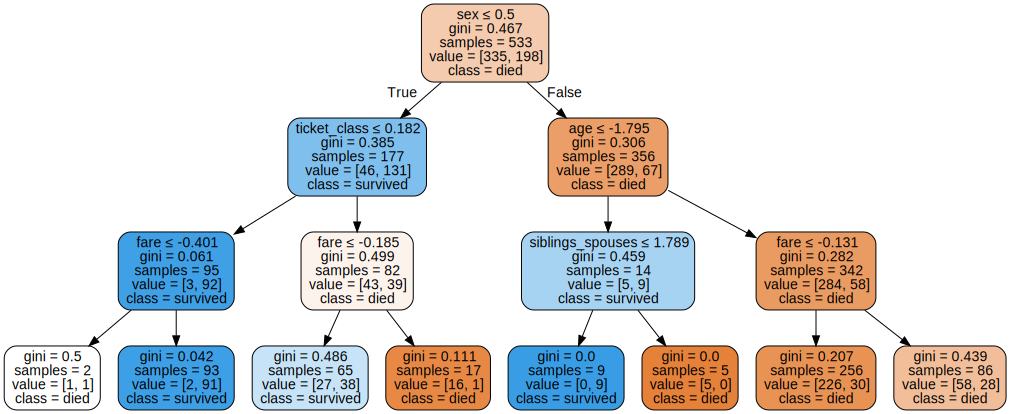

In [30]:
graph_tree(tree_model, label_binarizer_mapper.transformed_names_)

# Cuarto modelo: Random Forests

In [31]:
from sklearn.ensemble import RandomForestClassifier

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.988743,0.989796,0.979798,0.984772
test,0.752809,0.710145,0.671233,0.690141


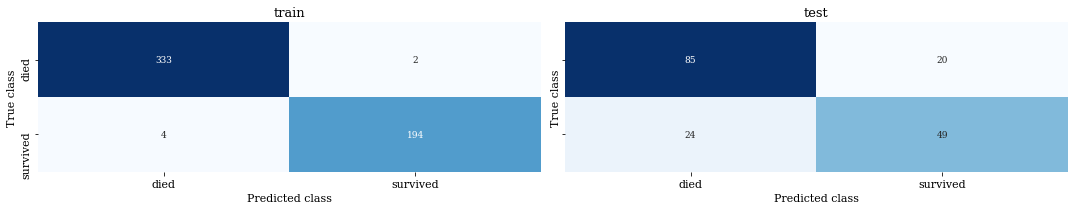

In [32]:
forest_model = RandomForestClassifier(random_state=42)
# n_estimators? max_depth=3?, max_features=2?

rf_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

rf_model.fit(train, train.survived)

evaluate_model(rf_model, title='Random Forest')

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.833021,0.909774,0.611111,0.731118
test,0.764045,0.829787,0.534247,0.650000


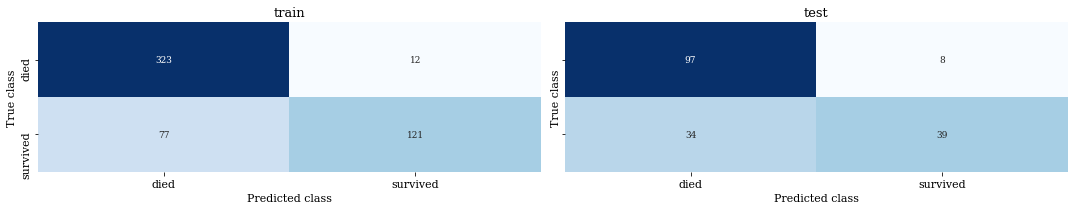

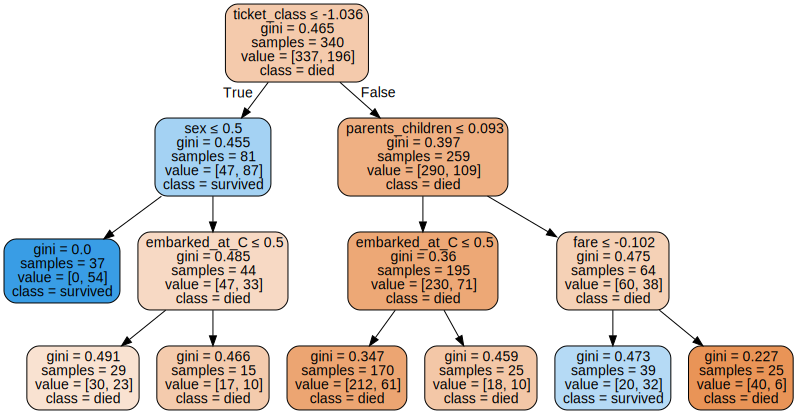

In [33]:
forest_model = RandomForestClassifier(n_estimators=100, max_depth=3, max_features=2, random_state=42)

rf_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

rf_model.fit(train, train.survived)

evaluate_model(rf_model, title='Random Forest')

graph_tree(forest_model.estimators_[0], col_names=label_binarizer_mapper.transformed_names_)

#### Bonus: Grid Search

In [34]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': [100, 200], 
              'max_depth':[3, 5, 8],
              'max_features': [2, 5]}


clf = GridSearchCV(forest_model, parameters, refit=True, verbose=1)

cv_pipe = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

cv_pipe.fit(train, train.survived)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   10.2s finished


Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['age'],
                                            [StandardScaler(copy=True,
                                                            with_mean=True,
                                                            with_std=True)]),
                                           (['siblings_spouses'],
                                            [StandardScaler(copy=True,
                                                            with_mean=True,
                                                            with_std=True)]),
                                           (['parents_children'],
                                            [StandardScaler(copy=True,
                                                            with_mean=True,
                                                            with_std=True)]),
                             

In [35]:
clf.best_score_, clf.best_params_

(0.8461470640098747, {'max_depth': 5, 'max_features': 5, 'n_estimators': 100})

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.833021,0.909774,0.611111,0.731118
test,0.764045,0.829787,0.534247,0.650000


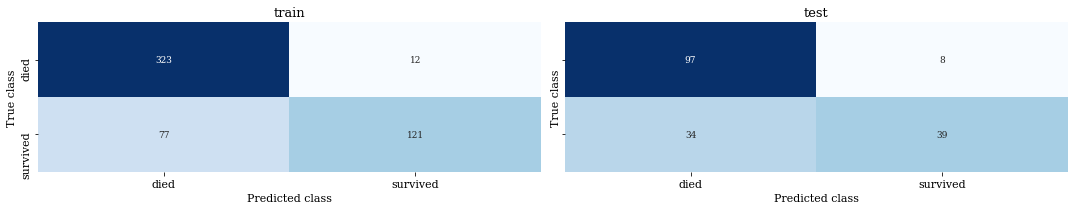

'Random Forest after Cross Validation'

,Accuracy,Precision,Recall,F1
train,0.879925,0.929487,0.732323,0.819209
test,0.792135,0.846154,0.602740,0.704000


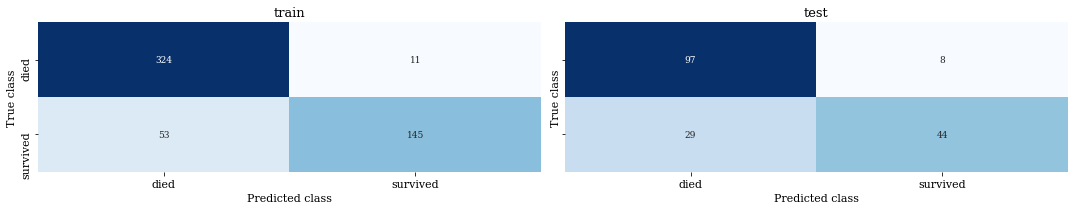

In [36]:
evaluate_model(rf_model, title='Random Forest')

evaluate_model(cv_pipe, title='Random Forest after Cross Validation')

# Quinto modelo: Gradient Boosted Trees

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
boost_model = GradientBoostingClassifier(random_state=42)

'Gradient Boosting'

,Accuracy,Precision,Recall,F1
train,0.932458,0.976471,0.838384,0.902174
test,0.792135,0.810345,0.643836,0.717557


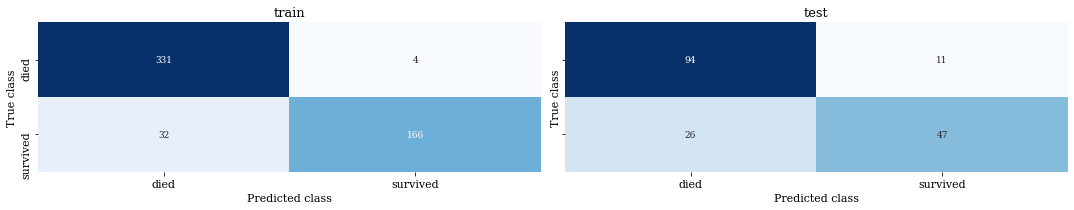

In [39]:
boo_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', boost_model),
])

boo_model.fit(train, train.survived)

evaluate_model(boo_model, title='Gradient Boosting')

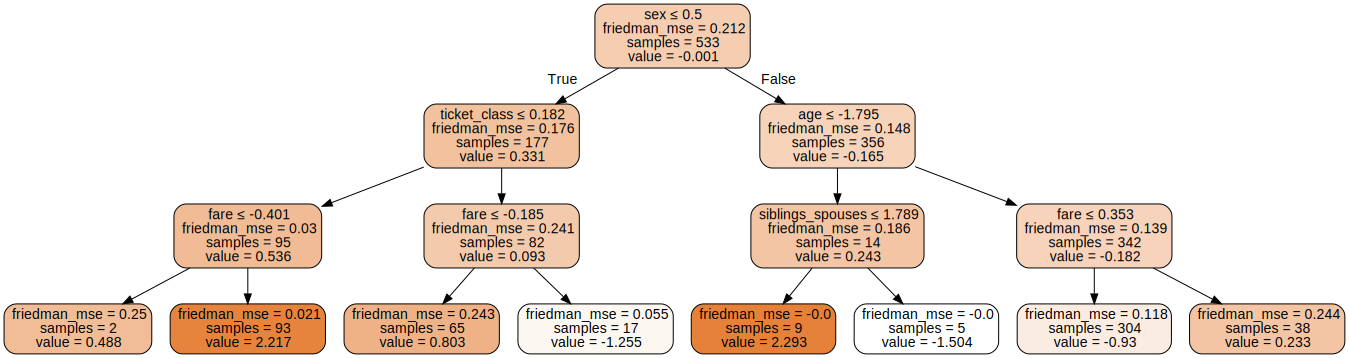

In [40]:
graph_tree(boost_model.estimators_[1][0], col_names=label_binarizer_mapper.transformed_names_)

#### Bonus: Features polinomicas en LR

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [41]:
from sklearn.preprocessing import PolynomialFeatures

'LR'

,Accuracy,Precision,Recall,F1
train,0.808630,0.769663,0.691919,0.728723
test,0.797753,0.784615,0.698630,0.739130


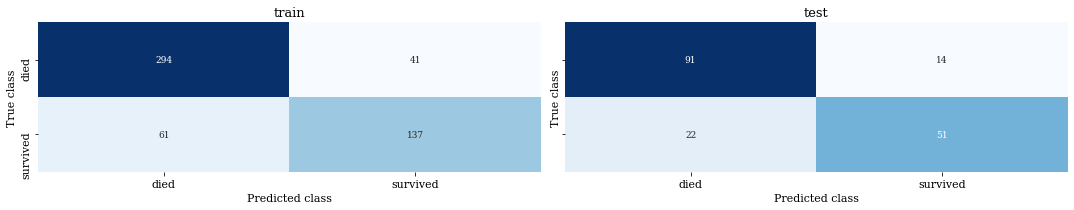

'LR con features polinomicas'

,Accuracy,Precision,Recall,F1
train,0.863039,0.893082,0.717172,0.795518
test,0.792135,0.821429,0.630137,0.713178


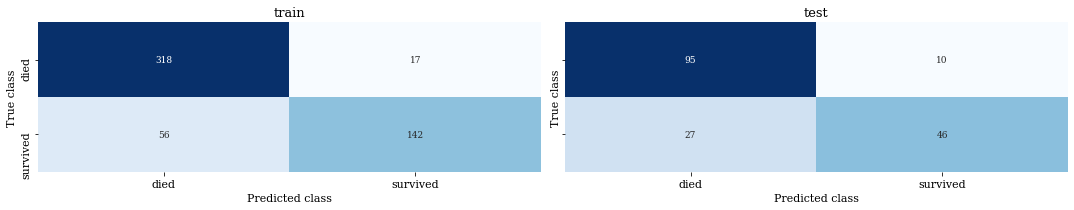

In [42]:
lr_model_pf = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('poli', PolynomialFeatures(degree=2)),
    ('classifier', LogisticRegression(max_iter=3000, random_state=42)),
])

lr_model_pf.fit(train, train.survived)

evaluate_model(lr_model_ii, title='LR')
evaluate_model(lr_model_pf, title='LR con features polinomicas')

## El mejor modelo...

* Considerando Accuracy 
* Accuracy esperado

Es accuracy la mejor métrica?


In [43]:
evaluate_model(lr_model_si, title='LR Simple Imputer', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(lr_model_ii, title='LR Iterative Imputer', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(lr_model_pf, title='LR con features polinomicas', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(knn_model, title='Knn', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(dt_model, title='Decision Tree', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(rf_model, title='Random Forest', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(cv_pipe, title='Random Forest after Cross Validation', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(boo_model, title='Gradient Boosting', set_names=('train', 'test', 'validation'), show_cm=False)

'LR Simple Imputer'

,Accuracy,Precision,Recall,F1
train,0.806754,0.768362,0.686869,0.725333
test,0.792135,0.772727,0.698630,0.733813
validation,0.808989,0.739726,0.782609,0.760563


'LR Iterative Imputer'

,Accuracy,Precision,Recall,F1
train,0.808630,0.769663,0.691919,0.728723
test,0.797753,0.784615,0.698630,0.739130
validation,0.825843,0.771429,0.782609,0.776978


'LR con features polinomicas'

,Accuracy,Precision,Recall,F1
train,0.863039,0.893082,0.717172,0.795518
test,0.792135,0.821429,0.630137,0.713178
validation,0.831461,0.819672,0.724638,0.769231


'Knn'

,Accuracy,Precision,Recall,F1
train,0.838649,0.858974,0.676768,0.757062
test,0.786517,0.830189,0.602740,0.698413
validation,0.825843,0.806452,0.724638,0.763359


'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.833021,0.826347,0.696970,0.756164
test,0.792135,0.821429,0.630137,0.713178
validation,0.792135,0.742424,0.710145,0.725926


'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.833021,0.909774,0.611111,0.731118
test,0.764045,0.829787,0.534247,0.650000
validation,0.820225,0.877551,0.623188,0.728814


'Random Forest after Cross Validation'

,Accuracy,Precision,Recall,F1
train,0.879925,0.929487,0.732323,0.819209
test,0.792135,0.846154,0.602740,0.704000
validation,0.825843,0.816667,0.710145,0.759690


'Gradient Boosting'

,Accuracy,Precision,Recall,F1
train,0.932458,0.976471,0.838384,0.902174
test,0.792135,0.810345,0.643836,0.717557
validation,0.876404,0.885246,0.782609,0.830769
